In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product



# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Datasets and DataLoaders
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Model Architecture

In [8]:
class ConvFCNet(nn.Module):
    def __init__(self, num_filters=32, filter_size=5, pool_size=3):
        super(ConvFCNet, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=3,
            out_channels=num_filters,   #32 filters because smaller network with just the one convolution layer
            kernel_size=filter_size  
        )
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=pool_size) 
        
        # input size is (3, 32, 32):
        # Conv layer with 5x5 kernel: (32, 28, 28)
        # MaxPool with 3x3 kernel: (32, 9, 9)
        
        self.fc = nn.Linear(num_filters * 9 * 9, 10)

    def forward(self, x):
        x = self.conv(x)           # Shape: (B, 32, 28, 28)
        x = self.relu(x)           # Shape: (B, 32, 28, 28)
        x = self.pool(x)           # Shape: (B, 32, 9, 9)
        x = x.view(x.size(0), -1)  # Flatten to (B, 32*9*9)
        x = self.fc(x)             # Output logits (B, 10)
        return x

In [9]:
net = ConvFCNet()

criterion = nn.CrossEntropyLoss() 
# this CE Loss has to include Softmax within it, a quick google search confirmed that it does

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# regular SGD with batches of 4, ADAM learning method with momentum and supposedly backprop written into it


Now the training loop

In [10]:
train_loss_list = []
test_acc_list = []
log_interval = 1000

for epoch in range(2):
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch+1}")

    for i, data in loop:
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100.0 * correct / total)

        if (i + 1) % log_interval == 0:
            # Average loss over log interval
            avg_loss = running_loss / log_interval
            train_loss_list.append(avg_loss)
            running_loss = 0.0
            correct = 0
            total = 0

            # Evaluate on test set
            net.eval()  # Set to evaluation mode
            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for test_data in testloader:
                    test_inputs, test_labels = test_data
                    test_outputs = net(test_inputs)
                    _, test_predicted = torch.max(test_outputs.data, 1)
                    test_total += test_labels.size(0)
                    test_correct += (test_predicted == test_labels).sum().item()
            test_accuracy = 100.0 * test_correct / test_total
            test_acc_list.append(test_accuracy)
            net.train()  # Set back to training mode
print('Finished Training')

Epoch 2: 100%|██████████| 12500/12500 [04:38<00:00, 44.95it/s, acc=60.6, loss=1.58]   

Finished Training


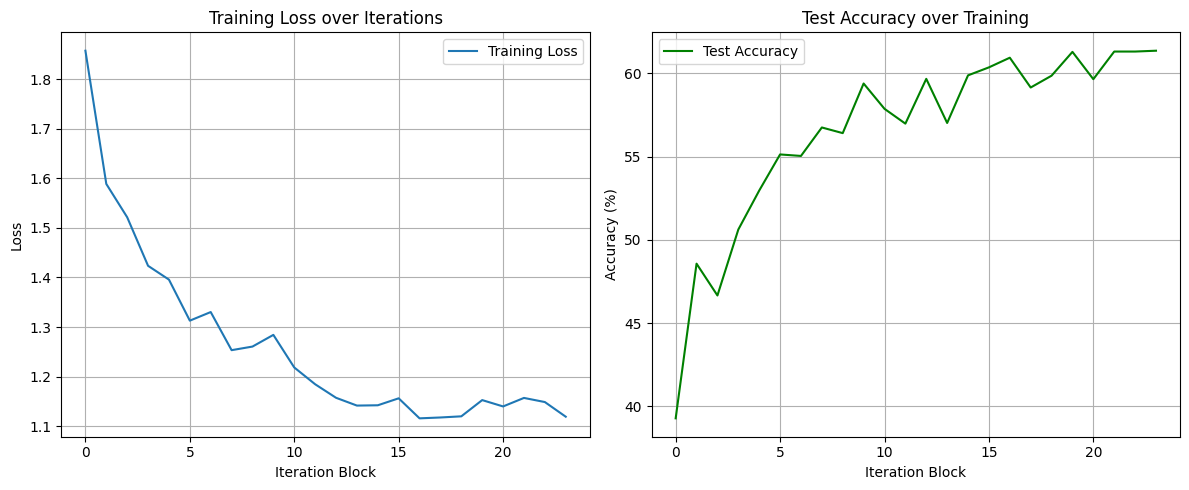

In [11]:


plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Iteration Block')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.grid(True)

# Plot Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(test_acc_list, label='Test Accuracy', color='green')
plt.xlabel('Iteration Block')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Training')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



Now for hyperparamter tuning we do the following: Lower learning rate, higher epochs, larger filter size

Epoch 20: 100%|██████████| 12500/12500 [03:20<00:00, 62.26it/s, acc=81.2, loss=0.184]  


 Finished Training


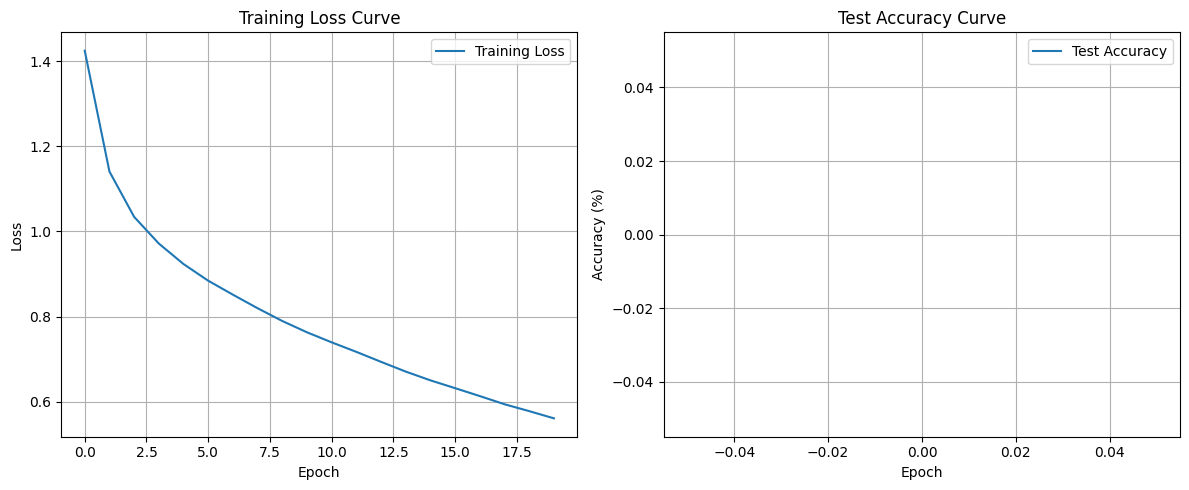

In [13]:
class ConvFCNet(nn.Module):
    def __init__(self, num_filters=64, filter_size=7, pool_size=3):
        super(ConvFCNet, self).__init__()
        self.conv = nn.Conv2d(3, num_filters, kernel_size=filter_size)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=pool_size)

        # Dynamically determine flatten size
        dummy = torch.zeros(1, 3, 32, 32)
        x = self.pool(self.relu(self.conv(dummy)))
        self.flatten_dim = x.view(1, -1).shape[1]

        self.fc = nn.Linear(self.flatten_dim, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# ---- Initialize Model, Loss, Optimizer ----
net = ConvFCNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)


# ---- Data Loaders with Normalization ----
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# ---- Model Definition ----
class ConvFCNet(nn.Module):
    def __init__(self, num_filters=64, filter_size=7, pool_size=2):
        super(ConvFCNet, self).__init__()
        self.conv = nn.Conv2d(3, num_filters, kernel_size=filter_size)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=pool_size)

        dummy = torch.zeros(1, 3, 32, 32)
        x = self.pool(self.relu(self.conv(dummy)))
        self.flatten_dim = x.view(1, -1).shape[1]

        self.fc = nn.Linear(self.flatten_dim, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# ---- Initialize Model, Loss, Optimizer ----
net = ConvFCNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

# ---- Training Loop with Metrics ----
EPOCHS = 20
train_loss_list = []
test_acc_list = []

for epoch in range(EPOCHS):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1}")
    for i, (inputs, labels) in loop:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

    # Record average training loss for the epoch
    train_loss_list.append(running_loss / len(trainloader))

if (i + 1) % 5000 == 0:
            # Average loss over log interval
            avg_loss = running_loss / log_interval
            train_loss_list.append(avg_loss)
            running_loss = 0.0
            correct = 0
            total = 0

            # Evaluate on test set
            net.eval()  # Set to evaluation mode
            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for test_data in testloader:
                    test_inputs, test_labels = test_data
                    test_outputs = net(test_inputs)
                    _, test_predicted = torch.max(test_outputs.data, 1)
                    test_total += test_labels.size(0)
                    test_correct += (test_predicted == test_labels).sum().item()
            test_accuracy = 100.0 * test_correct / test_total
            test_acc_list.append(test_accuracy)
            net.train()  # Set back to training mode

print(" Finished Training")

# ---- Plot Training Loss and Test Accuracy ----
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy Curve")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


okay, the accuracy curve is fucked for some reason, its too late in the morning for me to fix it, but takeaway: lower learning rate, bigger filter and bigger number of filters and more epochs increases accuracy by a lot. This model, weaker than the tutorial model achieves 81.2% accuracy.